we will analyze data from [Adult Data Set MLR](https://archive.ics.uci.edu/ml/datasets/Adult) which contains income data for about 32000 people. We will look at the data and build a machine learning model, which tries to predict if a person will make more than $50K a year, given data like education, gender and martial status.

Let's first import some libraries that we are going to need for our analysis
Original Blog post from https://www.valentinmihov.com/2015/04/17/adult-income-data-set/

In [5]:
# Collabedit http://collabedit.com/3cx7q
import pandas as pd
import numpy as np
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import sklearn.tree as tree
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pydotplus
import os

First we need to read the data from the file, which contains comma separated columns. With the command below we will read the data skipping any spaces before/after the commans and mark the values '?' as missing data points.

## Load the data

In [6]:
original_data = pd.read_csv(
    "adult.data.txt",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")
original_data.tail()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


## Analyze the data

Let's plot the distribution of each feature, so that we have a better understanding what we have in our data. We draw the number of values for each category feature and the histogram of the values for each continuous feature.

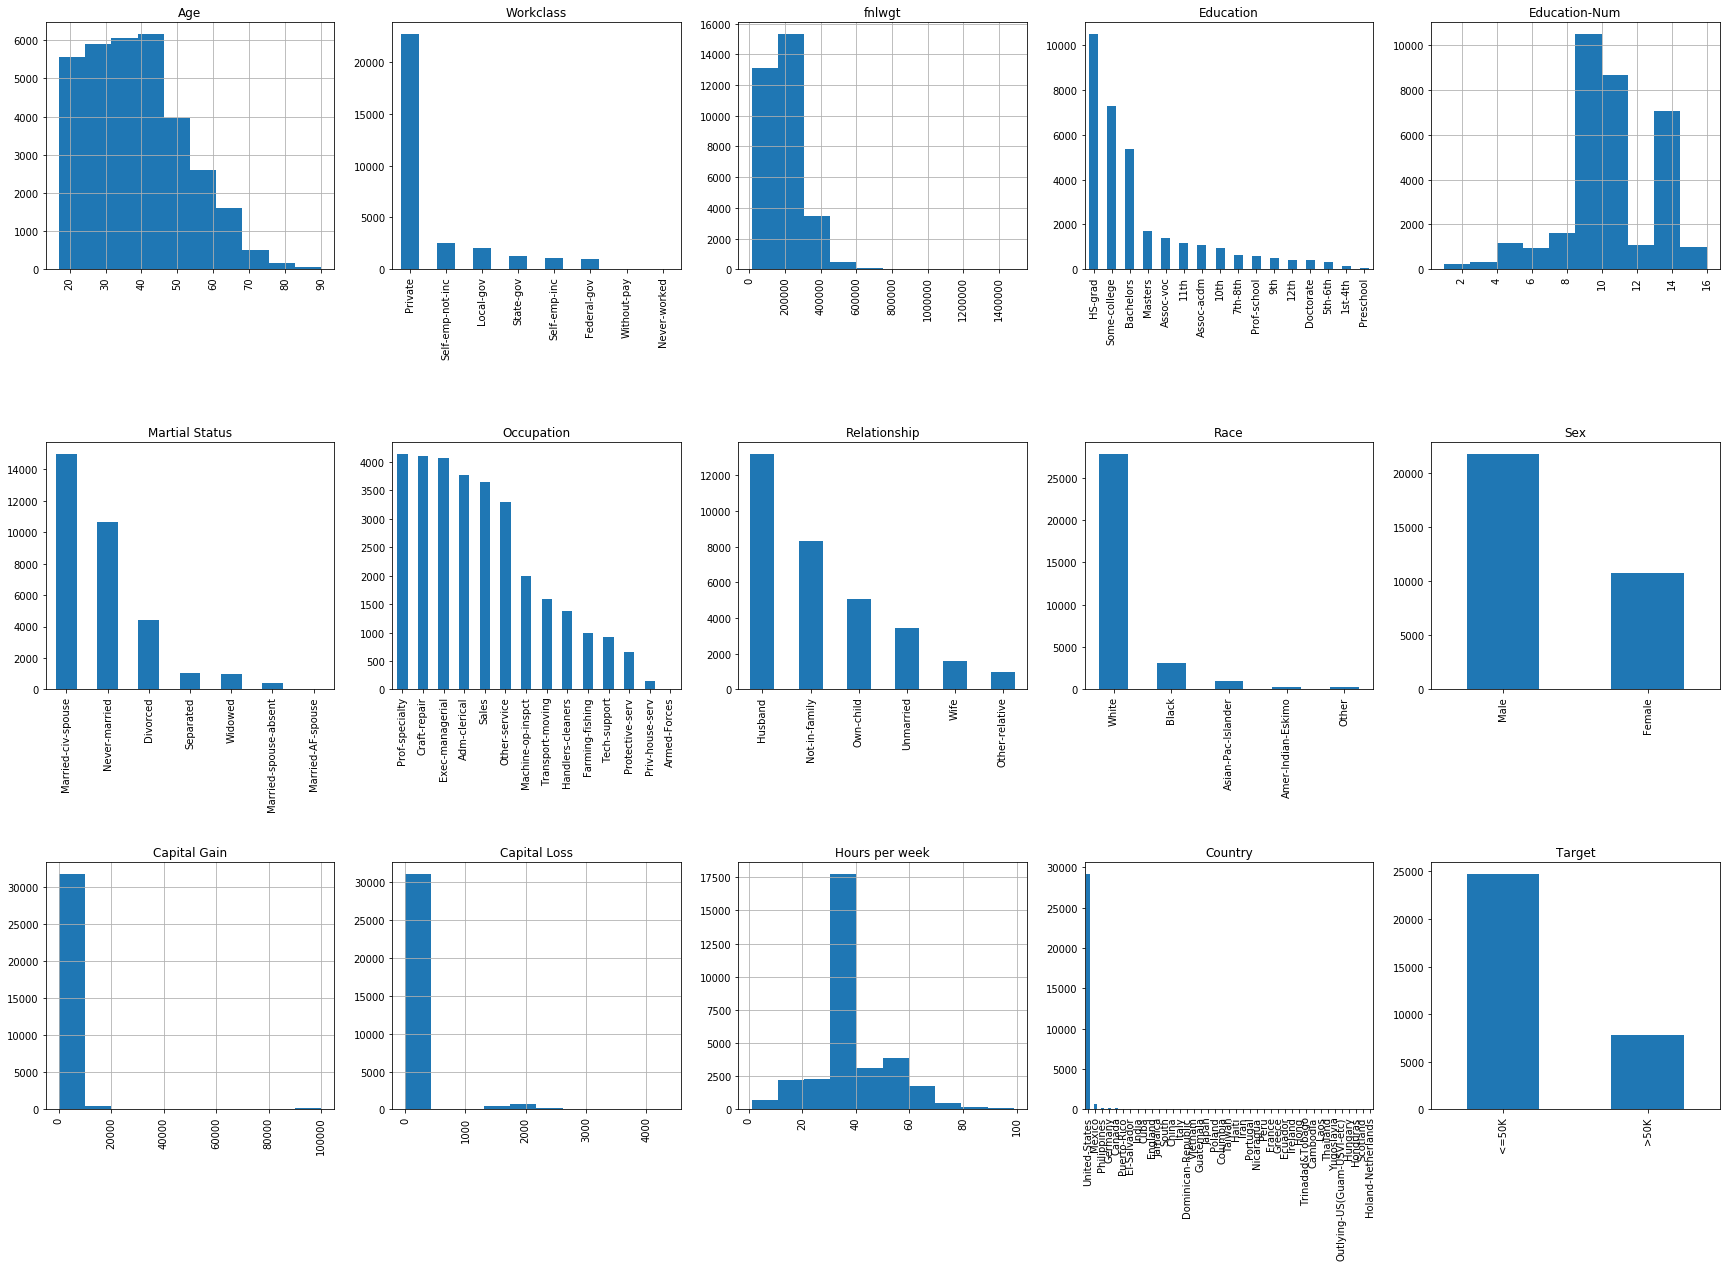

In [36]:
%matplotlib inline
fig = plt.figure(figsize=(30,20))
cols = 5
rows = math.ceil(float(original_data.shape[1]) / cols)
for i, column in enumerate(original_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if original_data.dtypes[column] == np.object:
        original_data[column].value_counts().plot(kind="bar", axes=ax)
    else:
        original_data[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

As you can see from the plots above our data is mostly concentrated in the USA with mostly male white people. This is a good thing to notice, as it may impact the conclusions we come to later.

In [7]:
(original_data["Country"].value_counts() / original_data.shape[0]).head()

United-States    0.895857
Mexico           0.019748
Philippines      0.006081
Germany          0.004207
Canada           0.003716
Name: Country, dtype: float64

Indeed! 89% of the samples are for people from the US. Mexico comes next
with less than 2%.

Now, let's explore something else. The correlation between the different
features. Generally it is not a good idea to have many correlated features, as
it might be a sign that your data is not very good. For this purpose
we will need to encode the categorical features as numbers. This can be done
using the `LabelEncoder` in the `scikit-learn` package.

In [11]:
# Encode the categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column].astype(str))
    return result, encoders
        

encoded_data, _ = number_encode_features(original_data)
encoded_data.tail()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
32556,27,3,257302,7,12,2,12,5,4,0,0,0,38,38,0
32557,40,3,154374,11,9,2,6,0,4,1,0,0,40,38,1
32558,58,3,151910,11,9,6,0,4,4,0,0,0,40,38,0
32559,22,3,201490,11,9,4,0,3,4,1,0,0,20,38,0
32560,52,4,287927,11,9,2,3,5,4,0,15024,0,40,38,1


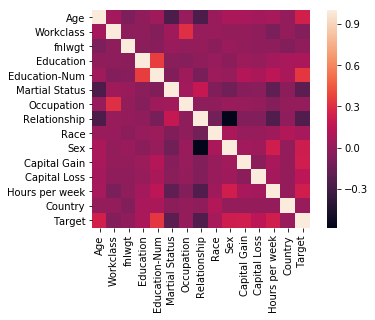

In [12]:
# Calculate the correlation and plot it
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

We see there is a high correlation between `Education` and `Education-Num`. Let's look at these columns

In [13]:
original_data[["Education", "Education-Num"]].head(15)

,Education,Education-Num
0,Bachelors,13
1,Bachelors,13
2,HS-grad,9
3,11th,7
4,Bachelors,13
5,Masters,14
6,9th,5
7,HS-grad,9
8,Masters,14
9,Bachelors,13


As you can see these two columns actually represent the same features, but encoded as strings and as numbers. We don't need the string representation, so we can just delete this column. Note that it is a much better option to delete the `Education` column as the `Education-Num` has the important property that the values are ordered: the higher the number, the higher the education that person has. This is a vaulable information a machine learning algorithm can use.

In [14]:
del original_data["Education"]

So it seems that the data is mostly OK with the exception of `Sex` and `Relationship`, which seems to be negatively correlated. Let's explore that for a bit. 

In [15]:
original_data[["Sex", "Relationship"]].head(15)

,Sex,Relationship
0,Male,Not-in-family
1,Male,Husband
2,Male,Not-in-family
3,Male,Husband
4,Female,Wife
5,Female,Wife
6,Female,Not-in-family
7,Male,Husband
8,Female,Not-in-family
9,Male,Husband


Since it is difficult to read the correlations by looking at datapoints, let's look at a cross-tabulation

In [16]:
pd.crosstab(original_data["Sex"],original_data["Relationship"])


Relationship,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
Sex,,,,,,
Female,1,3875,430,2245,2654,1566
Male,13192,4430,551,2823,792,2


In [13]:
pd.crosstab(original_data["Occupation"],original_data["Workclass"])

Workclass,Federal-gov,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay
Occupation,,,,,,,
Adm-clerical,317,283,2833,31,50,253,3
Armed-Forces,9,0,0,0,0,0,0
Craft-repair,64,146,3195,106,531,56,1
Exec-managerial,180,214,2691,400,392,189,0
Farming-fishing,8,29,455,51,430,15,6
Handlers-cleaners,23,47,1273,2,15,9,1
Machine-op-inspct,14,12,1913,13,36,13,1
Other-service,35,193,2740,27,175,124,1
Priv-house-serv,0,0,149,0,0,0,0


Although there was some correlation in the <i> numeric encodings of </i> occupation and work class, it is difficult to discern any strong patterns. We will leave this variable pair untouched as well.

## Build a classifier

Now that we explored our data, let's try to build a classifier which tries to predict what will be the income of a given person given the features we have in our dataset.

First we need to encode the features as numbers as the classifiers cannot work with string features. As we saw a while ago this can be achieved easily with the function we defined earlier. Let's encode the data and show the histograms of the values again.

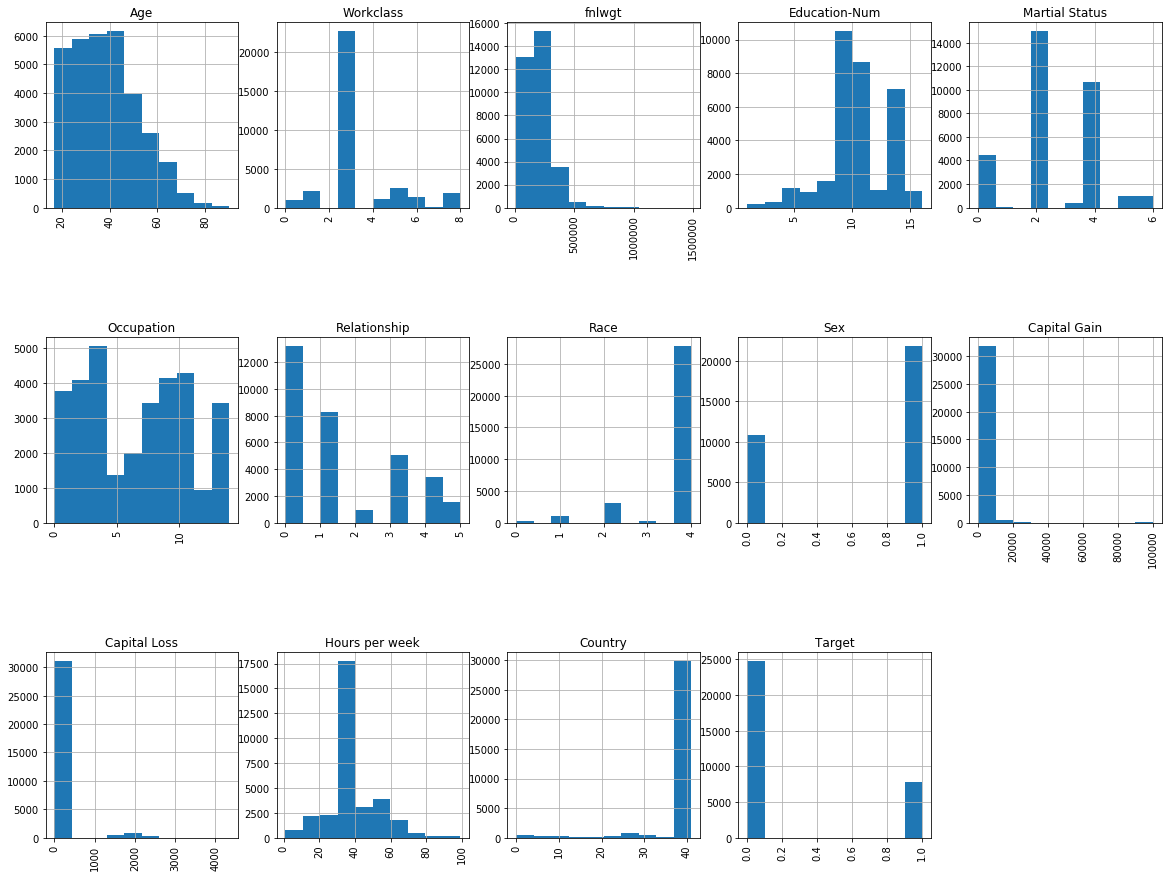

In [17]:
encoded_data, encoders = number_encode_features(original_data)
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(encoded_data.shape[1]) / cols)
for i, column in enumerate(encoded_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

As you can see we have our data properly encoded and it seems to make sense. Now, let's try to build a classifier for it. Before we do that, let's split the data into a train and test set. This is a common approach to avoid overfitting. If we train and test the classifiers on the same data we will always get awesome results and we will most probably overfit the model. However if we test a classifier on data it has never seen we can be more confident it will perform better when ran on new data.

## Split and scale the features

Most machine learning algorithms like the features to be scaled with mean 0 and variance 1. This is called "removing the mean and scaling to unit variance". This can be easily done with the `StandardScaler` from `scikit-learn`. Let's scale the features and look at them again.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(encoded_data[encoded_data.columns.drop("Target")], encoded_data["Target"], train_size=0.70,random_state=2)

In [19]:
X_train.tail()

,Age,Workclass,fnlwgt,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
11798,59,4,223215,13,2,3,0,4,1,0,1977,50,38
30280,25,3,169124,9,2,13,0,4,1,0,0,45,38
6637,46,0,43206,16,4,9,1,4,0,0,1564,50,38
2575,19,3,446219,6,4,11,4,2,0,0,0,40,38
23720,27,3,168470,13,4,3,1,4,1,0,0,40,38


In [20]:
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.astype("float")), columns=X_train.columns)
X_test = scaler.transform(X_test.astype("float"))
X_train.tail()

,Age,Workclass,fnlwgt,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
22787,1.481161,0.391216,0.312118,1.136235,-0.408112,-0.797238,-0.897996,0.392934,0.704084,-0.145055,4.674077,0.778758,0.250383
22788,-0.995034,-0.239824,-0.195787,-0.415254,-0.408112,1.519236,-0.897996,0.392934,0.704084,-0.145055,-0.216219,0.373913,0.250383
22789,0.534380,-2.132942,-1.378135,2.299851,0.919941,0.592646,-0.273713,0.392934,-1.420285,-0.145055,3.652483,0.778758,0.250383
22790,-1.432009,-0.239824,2.406087,-1.578870,0.919941,1.055941,1.599136,-1.966327,-1.420285,-0.145055,-0.216219,-0.030932,0.250383
22791,-0.849375,-0.239824,-0.201928,1.136235,0.919941,-0.797238,-0.273713,0.392934,0.704084,-0.145055,-0.216219,-0.030932,0.250383


### Logistic regression

In [21]:
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)

F1 score: 0.559512


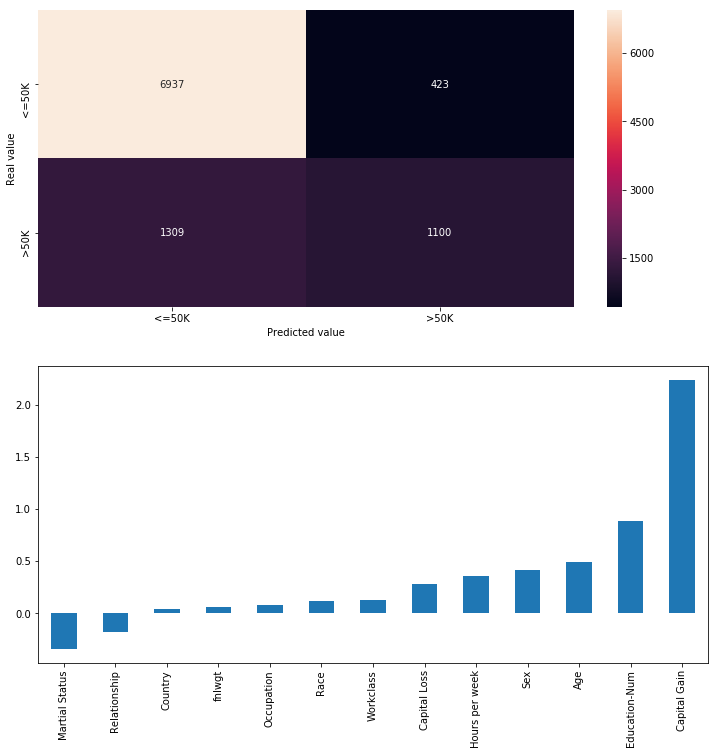

In [19]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=encoders["Target"].classes_, yticklabels=encoders["Target"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")
print "F1 score: %f" % skl.metrics.f1_score(y_test, y_pred)
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
coefs = coefs.sort_values()
plt.subplot(2,1,2)
coefs.plot(kind="bar")
plt.show()

As you can see we managed to achieve F1 score of 0.55 and the features that seems to contribute most positevely to have an income of more than $50K are `Capital Gain`, `Education-Num` and `Sex`, while the features that contribute most negatively are `Martia Status` and `Relationship`. There is a problem here, though. Features like `Martial Status` have values ranging from 0 to 6 and the order is really important here. In practice there is no particular order in that feature (unline `Education-Num` for which the higher the number, the better the education). We can fix this using *binary features*.

### Classify using binary features

As a last step we can try to improve our classifier using binary attributes. Our current approach for encoding our data has the drawback that we put arbitrary order in our classes. For example we encode `Relationship` with a number between 1 and 5 and the logistic regression interprets these values as continuous variables and plugs them into an optimization function. This will cause different classes to have different weight into our model, which is not correct. Each class is theoretically equally weighted compared to the rest of the classes. In order to fix this we can use dummy variables.

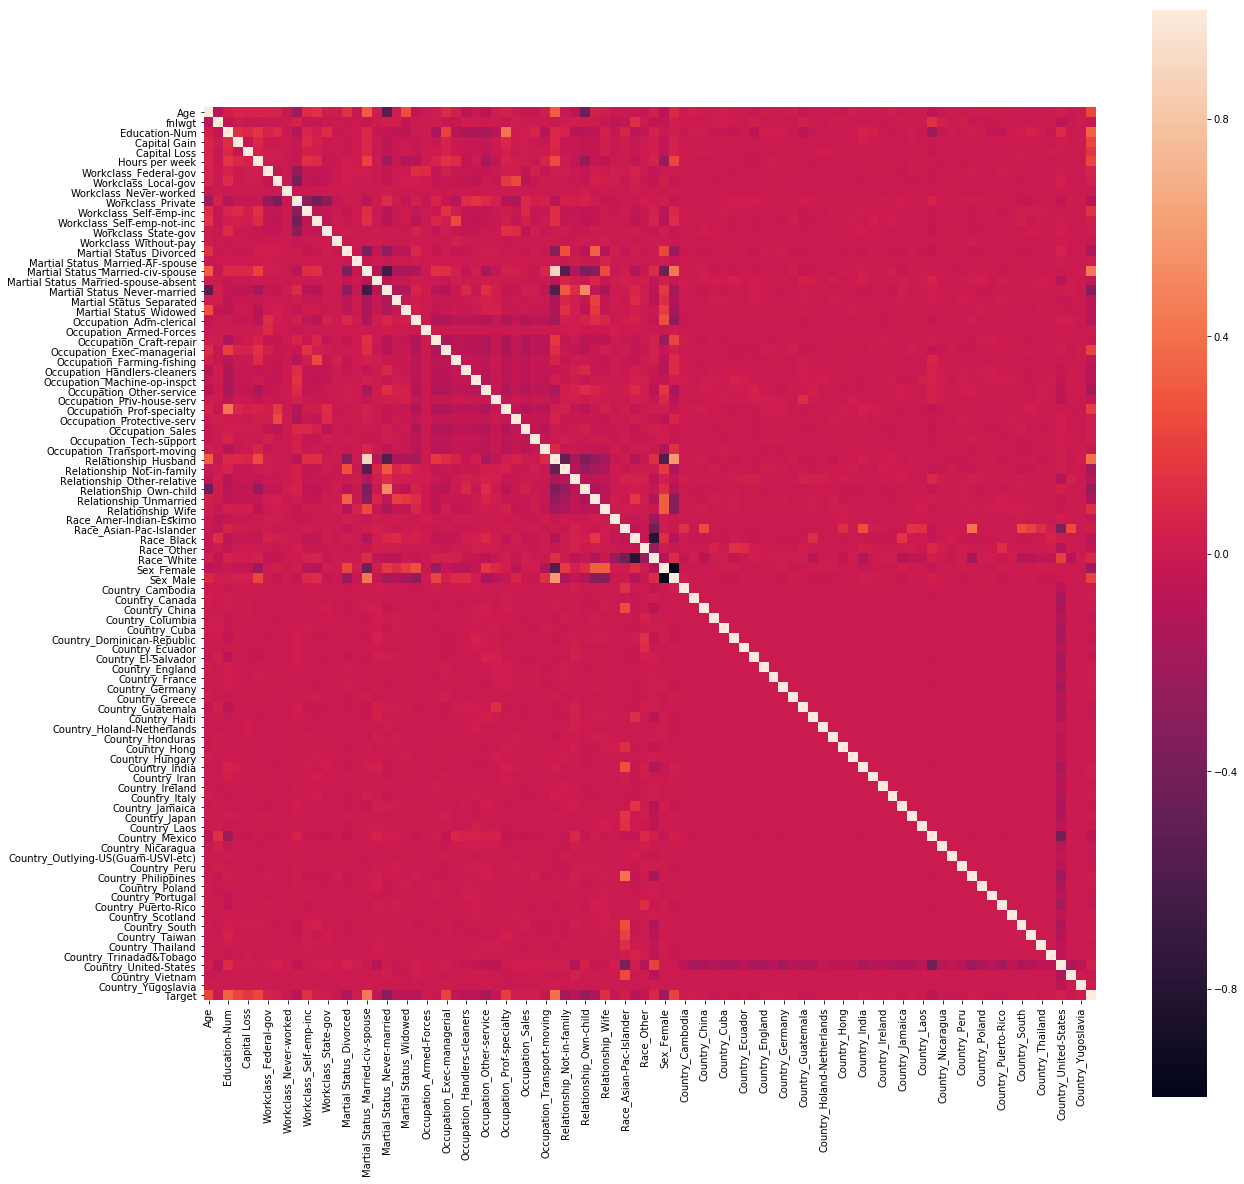

In [26]:
binary_data = pd.get_dummies(original_data)
# Let's fix the Target as it will be converted to dummy vars too
binary_data["Target"] = binary_data["Target_>50K"]
del binary_data["Target_<=50K"]
del binary_data["Target_>50K"]
plt.subplots(figsize=(20,20))
sns.heatmap(binary_data.corr(), square=True)
plt.show()

Now we have a bunch of features that have only the values 0 and 1. There is a lot of correlation between some of them, but let's not look at this for now (for example Male and Female are negatively correlated).

In [27]:
X_train, X_test, y_train, y_test = train_test_split(binary_data[binary_data.columns.drop("Target")], binary_data["Target"], train_size=0.70, random_state=2)
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

### Logistic Regression

F1 score: 0.657459


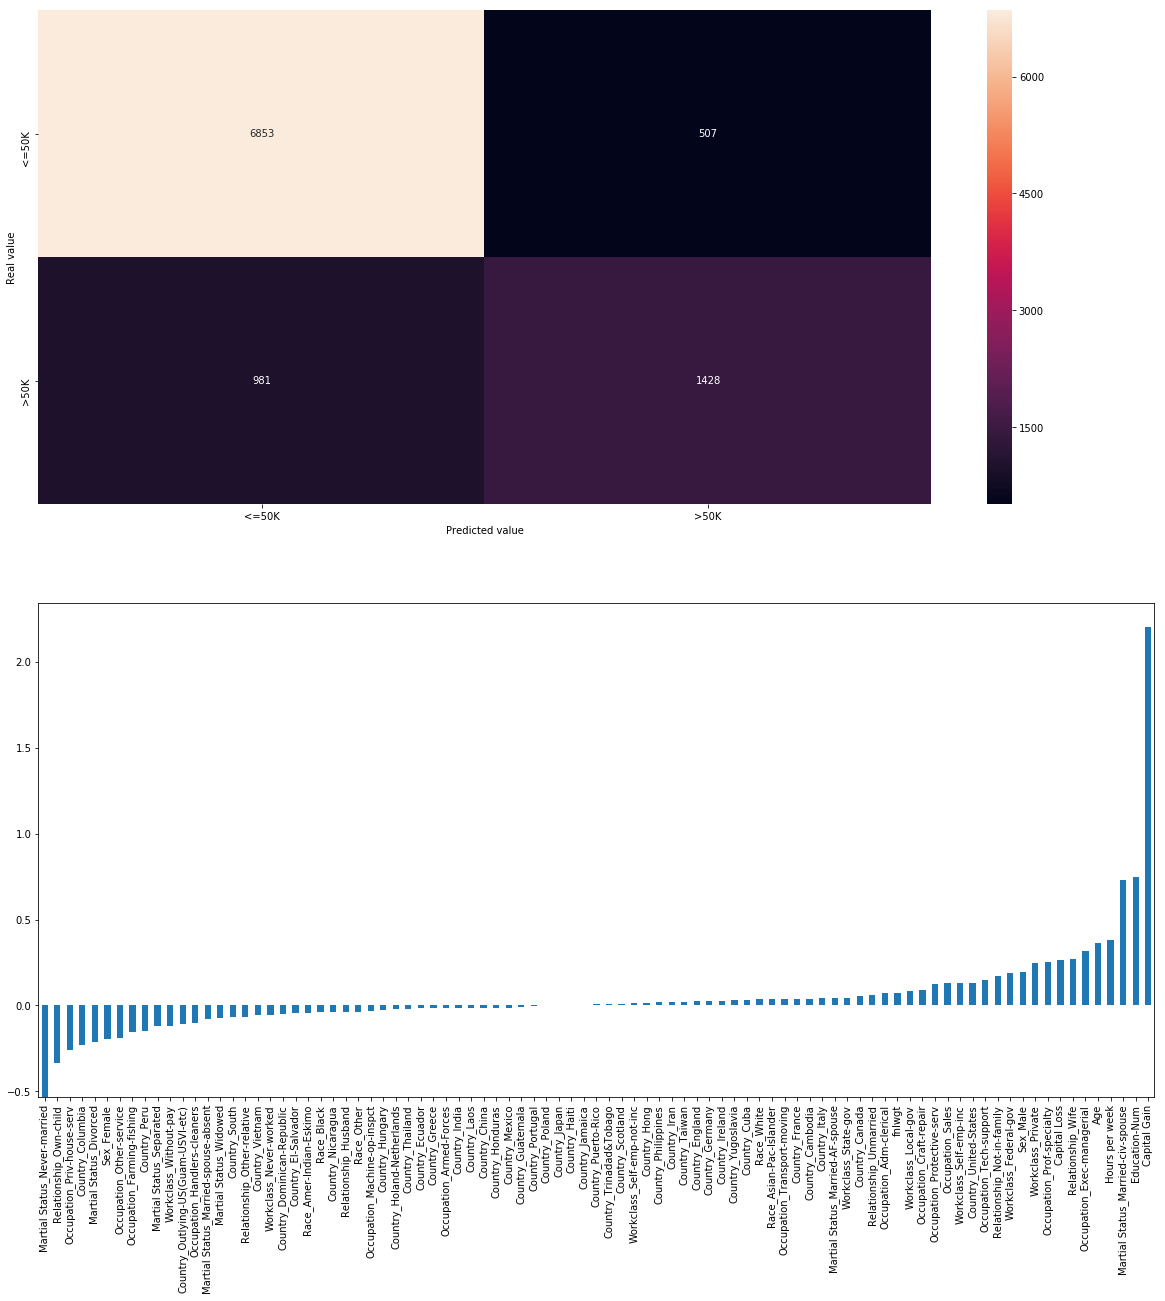

In [29]:
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred_lr = cls.predict(X_test)
cm_lr = metrics.confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
sns.heatmap(cm_lr, annot=True, fmt="d", xticklabels=encoders["Target"].classes_, yticklabels=encoders["Target"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")
print( "F1 score: %f" % skl.metrics.f1_score(y_test, y_pred_lr))
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
coefs = coefs.sort_values()
ax = plt.subplot(2,1,2)
coefs.plot(kind="bar")
plt.show()

### Decision Trees

In [ ]:
from sklearn import tree
from sklearn import grid_search
parameters = {'max_depth':range(3,20)}
parameters = {
        'max_depth': np.arange(3,20),
        'min_samples_split': (3, 5, 15),
        'min_samples_leaf': (3,5,15),
        'max_leaf_nodes': (None, 100, 200, 500, 1000),
    #'splitter': ('best','random'),
    'criterion': ('entropy','gini')
    }
clf_gs = grid_search.GridSearchCV(tree.DecisionTreeClassifier(), parameters, cv=10 , n_jobs=4,verbose=1,scoring='f1')
X_train, X_test, y_train, y_test = train_test_split(binary_data[binary_data.columns.drop("Target")], binary_data["Target"], train_size=0.70, random_state=2)
clf_gs.fit(X=X_train, y=y_train)
best_tree_model = clf_gs.best_estimator_
print (clf_gs.best_score_, clf_gs.best_params_) 

Fitting 10 folds for each of 1530 candidates, totalling 15300 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   34.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   58.7s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  7.3min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:  9.8min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed: 12.5min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed: 15.8min


In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=clf_gs.best_params_['max_depth'], min_samples_split=clf_gs.best_params_['min_samples_split'],max_leaf_nodes=clf_gs.best_params_['max_leaf_nodes'],criterion=clf_gs.best_params_['criterion'], min_samples_leaf=clf_gs.best_params_['min_samples_leaf'])
X_train, X_test, y_train, y_test = train_test_split(binary_data[binary_data.columns.drop("Target")], binary_data["Target"], train_size=0.70, random_state=2)
clf.fit(X_train,y_train)
y_pred_dt = clf.predict(X_test)
cm_dt = metrics.confusion_matrix(y_test, y_pred_dt)
cm_dt
print "F1 score: %f" % skl.metrics.f1_score(y_test, y_pred_dt)

In [34]:

print(clf_gs.best_score_)
print(clf_gs.best_params_['max_depth'])


0.683898513448
12


In [ ]:
with open("iris.dot", 'w') as f:
...     f = tree.export_graphviz(clf, out_file=f)
clf

In [ ]:

os.unlink('iris.dot')

In [ ]:
 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("iris.pdf") 


In [ ]:
from IPython.display import Image  
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  